In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

efield_list = [-0.1, -0.07, -0.05, -0.04, -0.03, -0.02, -0.01, 0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.1]

In [2]:
dos_data = {}
for efield in efield_list:
    with h5py.File(f"./data/dos_efield{efield}.h5", 'r') as f:
        dos = f['dos'][...]
        ygrid = f['y_grid'][...]
        egrid = f['e_grid'][...]
        dos_data[efield] = dos
        print(efield, egrid.shape)

# check the normalization of the dos
for efield in efield_list:
    dos_tmp = dos_data[efield]
    # now compute the integral of the dos on the ygrid and egrid plane
    integral = np.trapz(np.trapz(dos_tmp, x=egrid, axis=0), x=ygrid)
    # normalize the dos
    dos_data[efield] = dos_tmp / integral
    print(dos_data[efield].real.max())

-0.1 (4000,)
-0.07 (4000,)
-0.05 (4000,)
-0.04 (4000,)
-0.03 (4000,)
-0.02 (4000,)
-0.01 (4000,)
0.0 (4000,)
0.01 (4000,)
0.02 (4000,)
0.03 (4000,)
0.04 (4000,)
0.05 (4000,)
0.07 (4000,)
0.1 (4000,)
0.020951335256265954
0.018991629767724862
0.015378497839804621
0.014375810981889513
0.013560491385736326
0.012880031174916137
0.012303305765837968
0.011803999721263777
0.01136764798040444
0.010977483284748011
0.010622551551806412
0.010294530776690802
0.00998951234633267
0.009542771546543054
0.009783591121837399


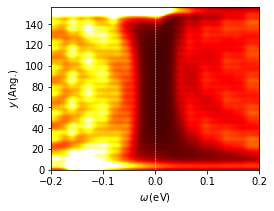

In [3]:
# Plot a heatmap of the real-space dos
fig, ax = plt.subplots(1,1,figsize=(20,3))
efield = -0.01
dos = dos_data[efield]
ax.imshow(dos.real.T, aspect=0.002, vmax=0.001, vmin=0.0,  
        extent=[egrid.min(), egrid.max(), ygrid.min(), ygrid.max()], cmap='hot')

ax.set_xlim([-0.2, 0.2])
ax.axvline(0, color='w', linestyle='--', lw=0.5)
ax.set_xlabel(r"$\omega\,$(eV)")
ax.set_ylabel(r"$y\,$(Ang.)")

fig.savefig(f"./figures/ribbon_dos_efield{efield}.png", dpi=480, bbox_inches='tight')

In [4]:
# let's plot the dos at the Fermi level

bias_to_plot_ind = np.arange(1980, 2020)

df_efermi = []
for efield in efield_list:
    dos_tmp = dos_data[efield]
    dos_fermi = dos_tmp[bias_to_plot_ind,:]
    for e_i in bias_to_plot_ind:
        dos_fermi = dos_tmp[e_i,:]
        for i, d in enumerate(dos_fermi):
            df_efermi.append({'efield': efield, 'y': ygrid[i], 
                              'dos': d.real, 'bias': egrid[e_i]})
df_efermi = pd.DataFrame(df_efermi)


In [5]:
df_efermi.bias.unique().shape

(40,)

[-2.00000000e-02 -1.00000000e-02 -2.20268248e-13  1.00000000e-02
  1.90000000e-02]


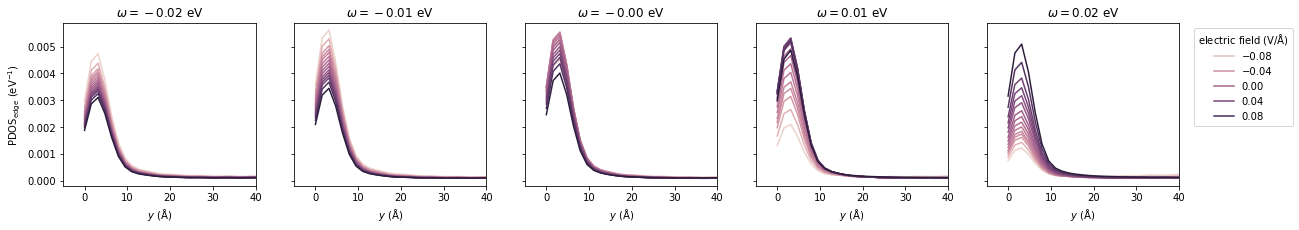

In [6]:
bias_to_plot = df_efermi.bias.unique()[[0, 10, 20, 30, -1]]
print(bias_to_plot)

fig, ax = plt.subplots(1, len(bias_to_plot),figsize=(4*len(bias_to_plot),3), sharey=True)
for iax, bias in zip(ax, bias_to_plot):
    if bias < bias_to_plot[-1]: legend_option = False
    else: legend_option = True
    sns.lineplot(data=df_efermi[df_efermi.bias==bias], x='y', y='dos',
                hue='efield', ax=iax,
                legend=legend_option)
    iax.set_xlim([-5, 40])
    iax.set_ylabel(r"PDOS$_{\mathrm{edge}}$ (eV$^{-1}$)")
    iax.set_xlabel(r"$y~(\mathrm{\AA})$")    

    iax.set_title(f"$\omega={bias:.2f}$ eV")

ax[-1].legend(title=r"electric field (V/$\mathrm{\AA}$)", 
              bbox_to_anchor=(1.05, 1), loc='upper left') 


fig.savefig(f"./figures/ribbon_dos_efields.pdf", bbox_inches='tight')    

In [7]:
# Now let's plot the spread in the y direction as a function of the bias and the electric field
df_spread = []
for efield in efield_list:
    dos_tmp = dos_data[efield]
    for e_i in bias_to_plot_ind:
        dos_e = dos_tmp[e_i,:]
        # fwhm = ygrid[np.where((dos_e<0.5*dos_e[:40].max()) & (ygrid<30))[0]]
        # y0, y1= fwhm[0], fwhm[-1]
        # if y0 > 8: fwhm = y0-0
        
        # fit the left peak to a gaussian, then get the fwhm
        y_select = ygrid[:30]
        dos_select = dos_e[:30]
        popt, _ = scipy.optimize.curve_fit(lambda x, a, b, c: a/(1+(x-c)**2/b**2), y_select, dos_select)
        fwhm = 2*abs(popt[1])

        df_spread.append({'efield': efield, 'bias': egrid[e_i],
                          'fwhm': fwhm})
df_spread = pd.DataFrame(df_spread)

/Users/yueqingheatherchang/opt/anaconda3/envs/pyqmc_dev/lib/python3.9/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


-6.418570183230653


/Users/yueqingheatherchang/opt/anaconda3/envs/pyqmc_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/yueqingheatherchang/opt/anaconda3/envs/pyqmc_dev/lib/python3.9/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


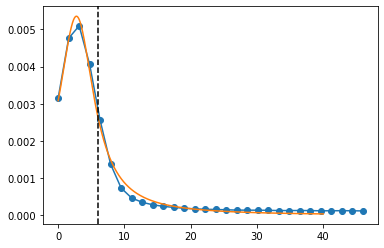

In [8]:
plt.plot(y_select, dos_select, 'o-')
# interpolate between y_select and dos_select


# fit to a lorentzian 
popt, _ = scipy.optimize.curve_fit(lambda x, a, b, c: a/(1+(x-c)**2/b**2), y_select, dos_select)

ygrid_dens = np.linspace(0, 40, 1000)
plt.plot(ygrid_dens, popt[0]/(1+(ygrid_dens-popt[2])**2/popt[1]**2))

# the width of the lorentzian is 2*b
fwhm = 2*popt[1]
print(fwhm)
# plot on the figure
plt.axvline(popt[2]-fwhm/2, color='k', linestyle='--')


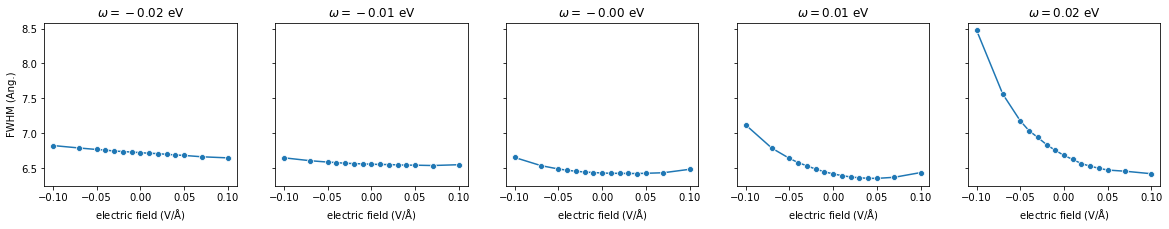

In [9]:
# now plot the fwhm as a function of efield for different biases
fig, ax = plt.subplots(1, len(bias_to_plot), figsize=(4*len(bias_to_plot),3), sharey=True)

for iax, bias in zip(ax, bias_to_plot):
    sns.lineplot(data=df_spread[df_spread.bias==bias], x='efield', y='fwhm', ax=iax, marker='o')
    iax.set_xlabel(r"electric field (V/$\mathrm{\AA}$)")
    iax.set_ylabel(r"FWHM (Ang.)")
    iax.set_title(f"$\omega={bias:.2f}$ eV")

fig.savefig(f"./figures/ribbon_dos_spread_summary.pdf", bbox_inches='tight')


In [11]:
df_spread.to_csv("./data/ribbon_pdos_spread_summary.csv", index=False)

In [10]:
# # now we try to get the extend of the edge state as a function of the efield value and the bias value (egrid)
# # Let's just look at the values within the gap.

# import scipy.interpolate


# efield_to_plot = efield_list

# # fig, ax = plt.subplots(len(efield_to_plot), 1,\
# #                         figsize=(3, 2*len(efield_to_plot)),\
# #                         sharex=True, sharey=True)

# # df_spread = []
# d_dos = {}
# for efield in efield_to_plot:
#     dos = dos_data[efield].real
#     # First, we need to find the gap region
#     emin, emax = -0.6, 0.6
#     egrid_nearef = egrid[(egrid>emin) & (egrid<emax)]
#     egrid_nearef_left = egrid[(egrid>emin) & (egrid<0.04)]
#     egrid_nearef_right = egrid[(egrid>0.04) & (egrid<emax)]
#     dos_nearef_all = dos[(egrid>emin) & (egrid<emax),:]
#     dos_nearef_left = dos[(egrid>emin) & (egrid<0.04)]
#     dos_nearef_right = dos[(egrid>0.04) & (egrid<emax)]
#     dos_nearef = dos[(egrid>emin) & (egrid<emax), 49]
#     left_max = np.max(dos_nearef_left).real
#     right_max = np.max(dos_nearef_right).real 

#     # get the left and right edge of the gap
#     smalldos_ind_left = np.where(dos_nearef_left>left_max*0.2)[0]
#     smalldos_ind_right = np.where(dos_nearef_right>right_max*0.2)[0]  

#     homo = egrid_nearef_left[smalldos_ind_left][-1]    
#     lumo = egrid_nearef_right[smalldos_ind_right][0]
#     efermi = 0.5*(lumo+homo)
#     gap = lumo - homo
#     print(efield, homo, lumo, gap, efermi)
    
#     # interpolate to get the dos at efermi using scipy
#     # this is a 2d interpolation, we have dos_nearef, egrid_nearef, ygrid
#     # now we need to get dos_efermi, which is an array of size same with ygrid
#     # but at energy efermi.
#     print(egrid_nearef.shape, ygrid.shape, dos_nearef_all.shape)
#     dos_efermi_func = scipy.interpolate.interp2d(ygrid, egrid_nearef, dos_nearef_all)
#     dos_efermi = dos_efermi_func(ygrid, [efermi])
#     print(dos_efermi.shape)
#     # save to the library
#     d_dos[f"efield{efield}"] = dos_efermi
    
#     # measure_ind = np.where(abs(egrid_nearef-efermi)<5e-4)
#     # for e_tmp in egrid_nearef[measure_ind]:
#     #     e_ind = np.where(egrid == e_tmp)
#     #     # then we get the dos at this energy
#     #     dos_tmp = dos[e_ind, :].squeeze()
#     #     iax.plot(ygrid, dos_tmp.real, 'o-')

#     #     dos_tmp_max = np.max(dos_tmp.real)
#     #     iax.axhline(dos_tmp_max*0.22, color='grey', ls='--', zorder=-10)
#     #     spread = np.where(abs(dos_tmp-dos_tmp_max*0.2)<2e-4)[0]
#     #     y_spread = ygrid[spread[0]]
#     #     iax.axvline(y_spread, color='grey', ls='--', zorder=-10)
#     #     df_spread.append({
#     #         "efield": efield,
#     #         "bias": 0.0,
#     #         "spread": y_spread,
#     #         "energy": e_tmp,
#     #         "efermi": efermi,
#     #     })

# # df = pd.DataFrame(df_spread)